# Anomaly detection for datacenter

You have collected logs of virtual machines working in datacenters (actually, the dataset is a real data from a number of real virtual machines). The logs are CPU load and memory load (RAM) for every VM. Your goal is to build a system detecting abnormal behavior of the VMs so that the system administrator can notice them and pay attention.

In [12]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture

In [2]:
from matplotlib.patches import Ellipse

In [3]:
%matplotlib inline

## Setting up the environment

The log file you are going to work with is `system-load.csv`. You may want to open it in text editor or Excel to examine its internal structure.

In [4]:
input_filename = "data/datacenter/system-load.csv"

## Loading the data

In [5]:
df_load = pd.read_csv(input_filename)

In [6]:
X = df_load.values

Let us take a look at the dataset.

In [7]:
df_load.head(5)

,cpu_load,ram_usage
0,1.29,290.0
1,2.66,332.0
2,0.88,372.0
3,2.57,362.0
4,2.44,480.0


In [8]:
X[:5]

array([[  1.29, 290.  ],
       [  2.66, 332.  ],
       [  0.88, 372.  ],
       [  2.57, 362.  ],
       [  2.44, 480.  ]])

In [80]:
X.shape

(936, 2)

## Training Gaussian mixture model

Train Gaussian mixture model on the datacenter data.

### Fuature Scaling

In [174]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array)

X_scaled.sample(5)

,0,1
586,1.365727,0.353015
37,1.486233,0.980328
251,0.208865,-0.311199
493,0.353473,-1.516625
720,0.329371,0.992628


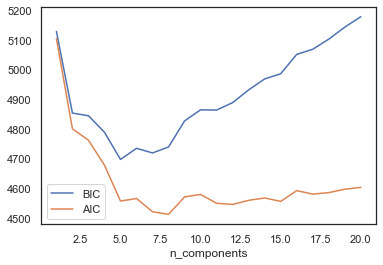

In [176]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(X_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [232]:
X_scale = X_scaled.to_numpy()
np.random.shuffle(X_scale)
perc80 = int(X_scale.shape[0]*0.8)

X_train, X_test = X_scale[:perc80], X_scale[perc80:]

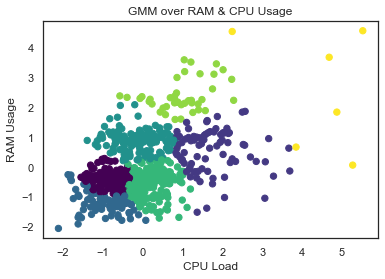

In [233]:
num_comp = 7
gmm = mixture.GaussianMixture(n_components=num_comp, covariance_type='spherical', random_state=0).fit(X_train)
labels = gmm.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=40, cmap='viridis')
plt.title('GMM over RAM & CPU Usage')
plt.xlabel('CPU Load')
plt.ylabel('RAM Usage');

In [234]:
print(gmm.converged_)

True


## Setting up model parameters

Set up the number of Gaussians and abnormality threshold. Note, there are no labels for the points in this dataset. We do not know which (if any) servers behaving abnormally. Think how would you decide on the threshold. Visualizing the results could help.

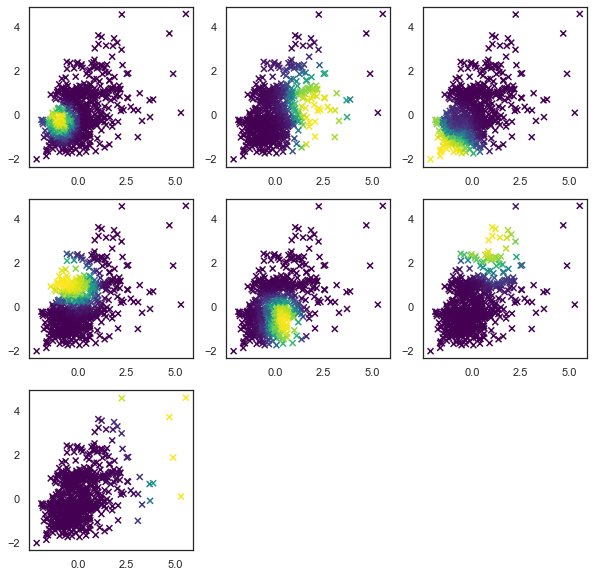

In [235]:
plt.figure(figsize=(10,10))
for i in range(num_comp):
    plt.subplot(3,3,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gmm.predict_proba(X_train)[:,i],cmap='viridis',marker='x');

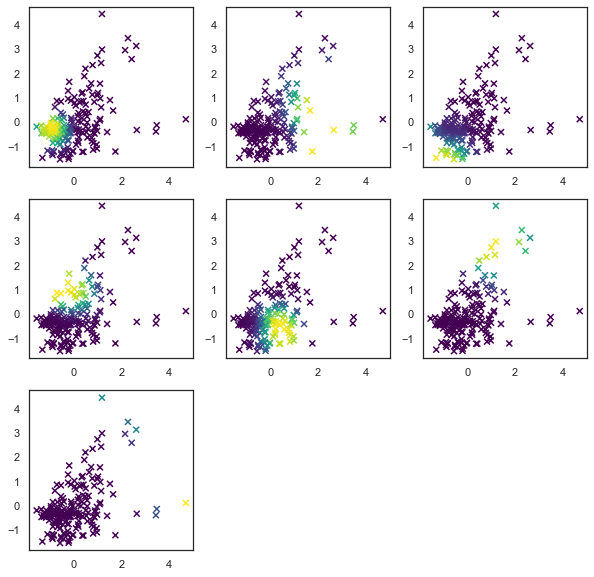

In [236]:
plt.figure(figsize=(10,10))
for i in range(num_comp):
    plt.subplot(3,3,i+1)
    plt.scatter(X_test[:,0],X_test[:,1],c=gmm.predict_proba(X_test)[:,i],cmap='viridis',marker='x');

#### Conclusion:
Data that falls into second and fifth clasters is abnormous. These are the spots that use unusualy large amount of CPU and RAM.\
To be exact, if data is in the claster `#2` then RAM usage is too big for the normal amount of CPU.\
if data is in the claster `#5` then the processes that use an appropriate amount of RAM need an abnomaously big amount of CPU Loads.

## Plotting the results

Visualize all the points from the dataset and density estimation of your model over them. Draw all abnormal points (falling below the threshold) in red.

#### Density visualisation

In [252]:
import scipy.stats as st

# Extract x and y
x = X_scale[:, 0]
y = X_scale[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

-2.8809200273404536 6.287209483774113 -2.706060131843473 5.22022830137725


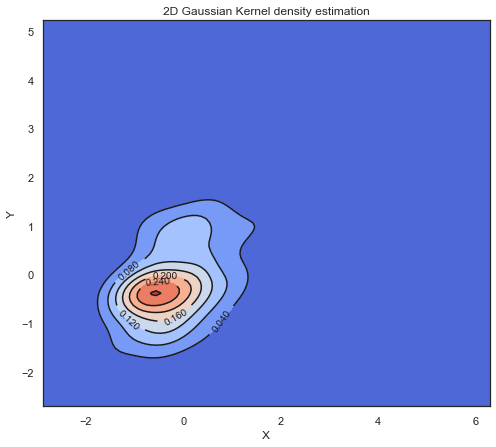

In [254]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation');

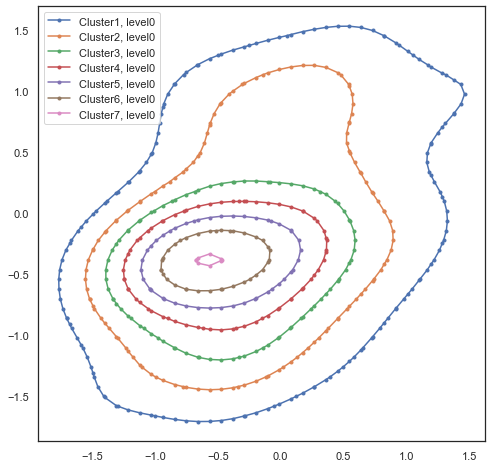

In [255]:
plt.figure(figsize=(8,8))
for j in range(len(cset.allsegs)):
    for ii, seg in enumerate(cset.allsegs[j]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=f'Cluster{j}, level{ii}')
plt.legend()

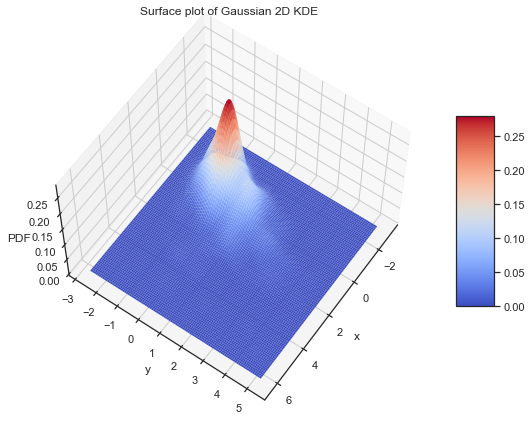

In [256]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

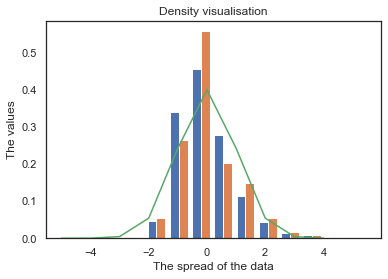

In [243]:
dist = norm(np.mean(X_scale), np.var(X_scale))
# sample probabilities for a range of outcomes
values = [value for value in range(-5, 5)]
probabilities = [dist.pdf(value) for value in values]

plt.hist(X_scale, bins=10, density=True)
plt.plot(values, probabilities)
plt.xlabel('The spread of the data')
plt.ylabel('The values')
plt.title('Density visualisation');

#### We can see that the data has Gaussian Distribution

In [266]:
def mean_var_normal(X):
    mu = np.mean(X,axis=0)
    var = np.var(X,axis=0)
    print("Mean: ", mu, " ,Var:", var)
    return mu,var

def pdf_normal(X, mu, sigma):
    k = len(mu)
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p

Mean:  [ 2.56205313e-16 -1.06277760e-16]  ,Var: [1. 1.]


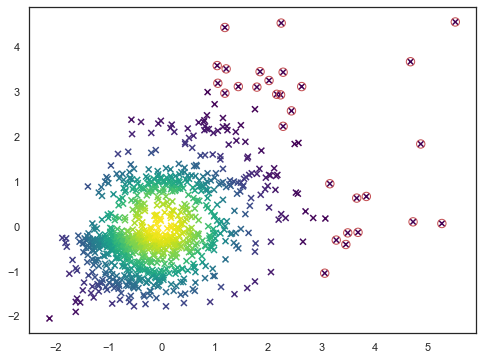

In [267]:
mu, sigma = mean_var_normal(X_scale)
p = pdf_normal(X_scale, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_scale[:,0],X_scale[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_scale[outliers,0],X_scale[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

### Conclusions:
We can see all the points, where it's important to take care of the system.